In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.init as init

import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Optional
import imageio
# import gdown # Removed, assuming data is downloaded
import dlib
from tqdm import tqdm
import warnings
import cv2
import time

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-dark-palette') # Use a compatible style
plt.rcParams["figure.figsize"] = (9, 5)

In [2]:
# --- Configuration ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
FRAME_COUNT = 75
FRAME_HEIGHT = 50
FRAME_WIDTH = 100
FRAME_CHANNELS = 3
DROPOUT_P = 0.5

BASE_PROCESSED_PATH = './processed_mouth_data/'
BASE_ALIGN_PATH = './data/alignments/'

ALL_SPEAKER_IDS = [f's{i}' for i in range(1, 2) if i != 21]

In [4]:
# TEST_SPEAKERS_UNSEEN = ['s1', 's2', 's20', 's22']
NUM_TEST_SENTENCES_OVERLAPPED = 200 
SPLIT_MODE = 'overlapped' # Choose 'unseen' or 'overlapped'

# Normalization constants
NORM_MEAN = np.array([0.7136, 0.4906, 0.3283], dtype=np.float32)
NORM_STD = np.array([0.1138, 0.1078, 0.0917], dtype=np.float32)

In [5]:
# --- Vocabulary ---
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz "]
char_to_num_dict = {char: i + 1 for i, char in enumerate(vocab)} # Start indices from 1
num_to_char_dict = {i + 1: char for i, char in enumerate(vocab)}
# Add OOV/padding token if needed by your collate logic, but CTC uses blank
VOCAB_SIZE = len(vocab)
CTC_BLANK_INDEX = 0 # CTC blank is often index 0 by convention in PyTorch
LABEL_PADDING_VALUE = CTC_BLANK_INDEX # Use blank index for padding labels

print(
    f"The vocabulary is: {vocab} "
    f"(size ={VOCAB_SIZE})"
)
print(f"CTC Blank Index: {CTC_BLANK_INDEX}")
print(f"Label Padding Value: {LABEL_PADDING_VALUE}")

The vocabulary is: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' '] (size =27)
CTC Blank Index: 0
Label Padding Value: 0


In [6]:
# --- Mouth Extraction (Mostly unchanged, ensure return type is numpy) ---
try:
    DLIB_LANDMARK_PREDICTOR = "shape_predictor_68_face_landmarks.dat"
    if not os.path.exists(DLIB_LANDMARK_PREDICTOR):
        # Add download/unzip logic here if needed, e.g., using requests/bz2
        print(f"Error: dlib landmark predictor '{DLIB_LANDMARK_PREDICTOR}' not found.")
        print("Please download it from http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2")
        exit()
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(DLIB_LANDMARK_PREDICTOR)
except Exception as e:
    print(f"Error initializing dlib: {e}")
    print("Make sure dlib is installed correctly and the predictor file exists.")
    exit()

def extract_mouth_region(frame: np.ndarray) -> Optional[np.ndarray]:
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) == 0:
        return None
    face = faces[0]
    landmarks = predictor(gray, face)
    points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 68)])

    x, y, w, h = cv2.boundingRect(points)
    # Adjust margins carefully - TF code used slightly different logic
    # Let's try to match the TF code's effective crop:
    y_start = max(y + 15 - 30, 0) # y + 15 was start, margin was 30
    y_end = y + 15 + h + 30
    x_start = max(x + 15 - 30, 0) # x + 15 was start, margin was 30
    x_end = x + 15 + w + 30

    # Ensure coordinates are within frame bounds
    y_start = max(0, y_start)
    y_end = min(frame.shape[0], y_end)
    x_start = max(0, x_start)
    x_end = min(frame.shape[1], x_end)

    cropped = frame[y_start:y_end, x_start:x_end]

    if cropped.size == 0: # Handle empty crop
        return np.zeros((FRAME_HEIGHT, FRAME_WIDTH, 3), dtype=np.uint8)

    try:
        cropped = cv2.resize(cropped, (FRAME_WIDTH, FRAME_HEIGHT))
        return cropped
    except cv2.error as e:
        print(f"Warning: cv2.resize error ({e}). Returning zero frame.")
        return np.zeros((FRAME_HEIGHT, FRAME_WIDTH, 3), dtype=np.uint8)

def process_and_save_video(video_path: str, output_dir: str) -> None:
    """Processes a single video, extracts mouth regions, and saves as .npy"""
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error opening video file: {video_path}")
            return None
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            mouth_frame = extract_mouth_region(frame)
            if mouth_frame is not None:
                frames.append(mouth_frame)
            else:
                # If detection fails, append a zero frame
                frames.append(np.zeros((FRAME_HEIGHT, FRAME_WIDTH, 3), dtype=np.uint8))
        cap.release()

        if not frames:
            print(f"Warning: No frames extracted from {video_path}")
            return None

        # Ensure video has FRAME_COUNT frames (pad/truncate if needed)
        frames_np = np.array(frames, dtype=np.uint8) # Keep as uint8 for now
        current_frame_count = frames_np.shape[0]
        if current_frame_count != FRAME_COUNT:
             if current_frame_count > FRAME_COUNT:
                 frames_np = frames_np[:FRAME_COUNT, ...]
             else:
                 pad_width = ((0, FRAME_COUNT - current_frame_count), (0, 0), (0, 0), (0, 0))
                 frames_np = np.pad(frames_np, pad_width, mode='constant', constant_values=0)

        video_id = os.path.splitext(os.path.basename(video_path))[0]
        output_path = os.path.join(output_dir, f"{video_id}_mouth.npy")
        np.save(output_path, frames_np)

    except Exception as e:
        print(f"Error processing video {video_path}: {e}")
    return None


# --- Function to preprocess all videos (Run only once) ---
def preprocess_all_videos(force_reprocess=False):
    print("Starting video preprocessing...")
    processed_count = 0
    skipped_count = 0
    for speaker_id in ALL_SPEAKER_IDS:
        input_videos_dir = os.path.join('./data/', speaker_id, 'video') # Assuming video folder structure
        output_preprocessed_dir = os.path.join(BASE_PROCESSED_PATH, speaker_id)
        os.makedirs(output_preprocessed_dir, exist_ok=True)

        print(f"Processing speaker: {speaker_id}")
        video_files = glob.glob(os.path.join(input_videos_dir, '*.mpg')) # Assuming .mpg format

        if not video_files:
             print(f"  Warning: No .mpg files found in {input_videos_dir}")
             continue

        for video_file in tqdm(video_files, desc=f"Speaker {speaker_id}", unit="video"):
             video_id = os.path.splitext(os.path.basename(video_file))[0]
             output_path = os.path.join(output_preprocessed_dir, f"{video_id}_mouth.npy")
             if not force_reprocess and os.path.exists(output_path):
                 skipped_count += 1
                 continue
             process_and_save_video(video_file, output_preprocessed_dir)
             processed_count += 1

    print(f"\nPreprocessing finished. Processed: {processed_count}, Skipped (already exists): {skipped_count}")

# --- UNCOMMENT AND RUN THIS ONCE TO PREPROCESS ---
# preprocess_all_videos(force_reprocess=False)
# print("Preprocessing complete. You can now comment out the preprocess_all_videos call.")
# --- END PREPROCESSING CALL ---

In [7]:
# --- GIF Creation (Unchanged) ---
def create_gif_from_npy(npy_path: str, gif_path: str, duration: float = 0.04) -> None:
    try:
        frames = np.load(npy_path) # Should be uint8
        imageio.mimsave(gif_path, frames, duration=duration)
    except FileNotFoundError:
        print(f"Warning: Npy file not found at {npy_path}, cannot create GIF.")
    except Exception as e:
        print(f"Error creating GIF from {npy_path}: {e}")
    return None

In [8]:
# --- Alignment Loading (Unchanged, returns list of chars) ---
def load_alignments(align_file: str) -> Optional[List[str]]:
    alignments_chars = []
    try:
        with open(align_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 3:
                    continue
                _, _, token = parts
                if token != 'sil':
                    token_characters = list(token.lower() + ' ')
                    alignments_chars.extend(token_characters)
        # Remove the trailing space from the last word
        return alignments_chars[:-1] if alignments_chars else []
    except FileNotFoundError:
         print(f"Warning: Alignment file not found: {align_file}")
         return None
    except Exception as e:
        print(f"Error loading alignments {align_file}: {e}")
        return None

In [9]:
example_alignment = load_alignments("./data/alignments/s1/lrwz4p.align")
print(example_alignment)

['l', 'a', 'y', ' ', 'r', 'e', 'd', ' ', 'w', 'i', 't', 'h', ' ', 'z', ' ', 'f', 'o', 'u', 'r', ' ', 'p', 'l', 'e', 'a', 's', 'e']


In [10]:
# --- File Listing and Splitting ---
all_npy_files = []
for speaker_id in ALL_SPEAKER_IDS:
    speaker_path = os.path.join(BASE_PROCESSED_PATH, speaker_id, '*.npy')
    files = glob.glob(speaker_path)
    if not files:
        print(f"Warning: No .npy files found for speaker {speaker_id} in {os.path.join(BASE_PROCESSED_PATH, speaker_id)}")
    all_npy_files.extend(files)

if not all_npy_files:
    raise FileNotFoundError(f"No .npy files found in {BASE_PROCESSED_PATH} for speakers {ALL_SPEAKER_IDS}. Did preprocessing run?")

np.random.shuffle(all_npy_files)
train_files, test_files = [], []

if SPLIT_MODE == 'unseen':
    print(f"Using unseen speakers split. Test speakers: {TEST_SPEAKERS_UNSEEN}")
    for f in all_npy_files:
        speaker_id = os.path.basename(os.path.dirname(f))
        if speaker_id in TEST_SPEAKERS_UNSEEN:
            test_files.append(f)
        else:
            train_files.append(f)
elif SPLIT_MODE == 'overlapped':
    print(f"Using overlapped speakers split. {NUM_TEST_SENTENCES_OVERLAPPED} test sentences per speaker.")
    files_by_speaker = {}
    for f in all_npy_files:
        speaker_id = os.path.basename(os.path.dirname(f))
        if speaker_id not in files_by_speaker:
            files_by_speaker[speaker_id] = []
        files_by_speaker[speaker_id].append(f)

    for speaker_id, files in files_by_speaker.items():
        np.random.shuffle(files)
        test_count = min(NUM_TEST_SENTENCES_OVERLAPPED, len(files))
        test_files.extend(files[:test_count])
        train_files.extend(files[test_count:])
else:
    raise ValueError("Invalid SPLIT_MODE. Choose 'unseen' or 'overlapped'.")

print(f"Total files found: {len(all_npy_files)}")
print(f"Training files: {len(train_files)}")
print(f"Test files: {len(test_files)}")

if not train_files or not test_files:
    raise ValueError("Training or test set is empty. Check file paths and splitting logic.")

Using overlapped speakers split. 200 test sentences per speaker.
Total files found: 995
Training files: 795
Test files: 200


In [11]:
# --- PyTorch Dataset ---
class GRIDDataset(Dataset):
    def __init__(self, file_paths: List[str], augment: bool = False):
        self.file_paths = file_paths
        self.augment = augment
        self.target_frame_count = FRAME_COUNT # Define target length

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        npy_path = self.file_paths[idx]
        try:
            # --- Load Frames (Keep as uint8 for now) ---
            # This part loads the preprocessed mouth crops saved earlier
            frames_uint8 = np.load(npy_path)

            if frames_uint8.ndim != 4 or frames_uint8.shape[1:] != (FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS):
                 print(f"Warning: Unexpected shape {frames_uint8.shape} for {npy_path}. Skipping.")
                 # Return dummy data that collate_fn can handle/filter
                 return torch.zeros((FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS), dtype=torch.float32), \
                        torch.tensor([], dtype=torch.long)

            # --- Ensure Correct Frame Count ---
            current_frame_count = frames_uint8.shape[0]
            if current_frame_count != self.target_frame_count:
                if current_frame_count > self.target_frame_count:
                    # Truncate
                    frames_uint8 = frames_uint8[:self.target_frame_count, ...]
                else:
                    # Pad with zeros
                    pad_width = ((0, self.target_frame_count - current_frame_count), (0, 0), (0, 0), (0, 0))
                    # Ensure padding uses the correct dtype (uint8) before conversion
                    frames_uint8 = np.pad(frames_uint8, pad_width, mode='constant', constant_values=0)

            # --- Convert to Float, Normalize, Convert BGR->RGB ---
            frames_float = frames_uint8.astype(np.float32) / 255.0
            frames_rgb = frames_float[..., ::-1] # BGR to RGB
            frames_normalized = (frames_rgb - NORM_MEAN) / NORM_STD
            frames_tensor = torch.tensor(frames_normalized, dtype=torch.float32)
            # Shape should now be guaranteed [75, 50, 100, 3]

            # --- Get Alignments ---
            # (Rest of your alignment loading logic remains the same)
            parts = npy_path.split(os.path.sep)
            speaker_id = parts[-2]
            base_name = os.path.splitext(parts[-1])[0]
            if base_name.endswith('_mouth'):
                base_name = base_name[:-6]
            align_file = os.path.join(BASE_ALIGN_PATH, speaker_id, f'{base_name}.align')
            alignments_list = load_alignments(align_file)

            if alignments_list is None:
                print(f"Skipping {npy_path} due to missing alignment.")
                return torch.zeros((FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS), dtype=torch.float32), \
                       torch.tensor([], dtype=torch.long)

            label_indices = [char_to_num_dict.get(char, CTC_BLANK_INDEX) for char in alignments_list] # Use blank for OOV
            label_tensor = torch.tensor(label_indices, dtype=torch.long)

            # --- Augmentation (Applied AFTER ensuring correct shape and normalization) ---
            if self.augment and torch.rand(1).item() > 0.5:
                frames_tensor = torch.flip(frames_tensor, dims=[2]) # Flip width dimension

            return frames_tensor, label_tensor

        except FileNotFoundError:
            print(f"Warning: File not found {npy_path}. Skipping.")
            return torch.zeros((FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS), dtype=torch.float32), \
                   torch.tensor([], dtype=torch.long)
        except Exception as e:
            print(f"Error loading item {idx} ({npy_path}): {e}")
            return torch.zeros((FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS), dtype=torch.float32), \
                   torch.tensor([], dtype=torch.long)

In [12]:
# --- Collate Function ---
def collate_fn(batch):
    # Filter out samples where loading failed (indicated by empty label tensor)
    batch = [(frames, labels) for frames, labels in batch if labels.numel() > 0]
    if not batch:
        # Return empty tensors if the whole batch failed
        return torch.tensor([]), torch.tensor([]), torch.tensor([]), torch.tensor([])

    # Separate frames and labels
    frames_list, labels_list = zip(*batch)

    # Stack frames (already same size T, H, W, C)
    frames_batch = torch.stack(frames_list, dim=0)

    # Pad labels
    label_lengths = torch.tensor([len(lbl) for lbl in labels_list], dtype=torch.long)
    labels_padded = pad_sequence(labels_list, batch_first=True, padding_value=LABEL_PADDING_VALUE)

    # Input lengths for CTC (fixed frame count here)
    input_lengths = torch.full(size=(len(batch),), fill_value=FRAME_COUNT, dtype=torch.long)

    return frames_batch, labels_padded, input_lengths, label_lengths

In [13]:
# --- Data Loaders ---
BATCH_SIZE_TRAIN = 32 # Adjust based on GPU memory
BATCH_SIZE_TEST = 32

train_dataset = GRIDDataset(train_files, augment=True)
test_dataset = GRIDDataset(test_files, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True,
                          collate_fn=collate_fn, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False,
                         collate_fn=collate_fn, num_workers=4, pin_memory=True)

print("DataLoaders created.")
# Optional: Test one batch
try:
    d_frames, d_labels, d_in_len, d_lbl_len = next(iter(train_loader))
    print("Train Batch Shapes:", d_frames.shape, d_labels.shape, d_in_len.shape, d_lbl_len.shape)
    d_frames, d_labels, d_in_len, d_lbl_len = next(iter(test_loader))
    print("Test Batch Shapes:", d_frames.shape, d_labels.shape, d_in_len.shape, d_lbl_len.shape)
except Exception as e:
     print(f"Error fetching batch: {e}")


DataLoaders created.
Train Batch Shapes: torch.Size([32, 75, 50, 100, 3]) torch.Size([32, 28]) torch.Size([32]) torch.Size([32])
Test Batch Shapes: torch.Size([32, 75, 50, 100, 3]) torch.Size([32, 30]) torch.Size([32]) torch.Size([32])


In [14]:
# --- PyTorch LipNet Model ---
class LipNet(nn.Module):
    def __init__(self, num_classes, dropout_p=DROPOUT_P):
        super(LipNet, self).__init__()
        self.num_classes = num_classes # Should include blank token
        self.dropout_p = dropout_p

        # Spatiotemporal Convolutional Layers (STCNN)
        self.conv1 = nn.Conv3d(FRAME_CHANNELS, 32, kernel_size=(3, 5, 5), stride=(1, 2, 2), padding=(1, 2, 2))
        self.bn1 = nn.BatchNorm3d(32)
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.drop1 = nn.Dropout3d(dropout_p) # Using Dropout3d for spatial dropout effect

        self.conv2 = nn.Conv3d(32, 64, kernel_size=(3, 5, 5), stride=(1, 1, 1), padding=(1, 2, 2))
        self.bn2 = nn.BatchNorm3d(64)
        self.pool2 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.drop2 = nn.Dropout3d(dropout_p)

        self.conv3 = nn.Conv3d(64, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.bn3 = nn.BatchNorm3d(96)
        self.pool3 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.drop3 = nn.Dropout3d(dropout_p)

        # Calculate flattened feature size after STCNN and pooling
        # Input: (N, C, T, H, W) = (N, 3, 75, 50, 100)
        # After conv1+pool1: (N, 32, 75, 12, 25) # H=(50/2)/2=12, W=(100/2)/2=25
        # After conv2+pool2: (N, 64, 75, 6, 12)  # H=(12/2)=6, W=(25/2)=12
        # After conv3+pool3: (N, 96, 75, 3, 6)   # H=(6/2)=3, W=(12/2)=6
        self.rnn_input_size = 96 * 3 * 6 # C_out * H_out * W_out

        # Bidirectional GRU Layers
        self.gru1 = nn.GRU(self.rnn_input_size, 256, bidirectional=True, batch_first=True)
        self.drop_gru1 = nn.Dropout(dropout_p)
        self.gru2 = nn.GRU(256 * 2, 256, bidirectional=True, batch_first=True) # Input size is doubled from previous BiGRU
        self.drop_gru2 = nn.Dropout(dropout_p)

        # Fully Connected Layer
        self.fc = nn.Linear(256 * 2, self.num_classes)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        # Kaiming (He) for Conv, Xavier (Glorot) for GRU kernel, Orthogonal for GRU recurrent
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.GRU):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name: # Input-hidden weights
                        init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name: # Hidden-hidden weights
                        init.orthogonal_(param.data)
                    elif 'bias' in name: # Biases
                        init.constant_(param.data, 0)
                        # Optional: Set forget gate bias to 1 (not directly applicable to GRU like LSTM)
            elif isinstance(m, nn.Linear):
                 init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') # He for Dense
                 if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        # Input shape: (N, T, H, W, C) from DataLoader
        # Permute to (N, C, T, H, W) for Conv3D
        x = x.permute(0, 4, 1, 2, 3).contiguous()

        # STCNN blocks
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.drop2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.drop3(x)

        # Reshape for RNN: (N, C, T, H, W) -> (N, T, C*H*W)
        N, C, T, H, W = x.size()
        x = x.permute(0, 2, 1, 3, 4).contiguous() # (N, T, C, H, W)
        x = x.view(N, T, -1) # Flatten C, H, W dims

        # Bi-GRU layers
        x, _ = self.gru1(x)
        x = self.drop_gru1(x)
        x, _ = self.gru2(x)
        x = self.drop_gru2(x)

        # Fully Connected Layer
        x = self.fc(x) # Output shape: (N, T, num_classes)

        # Prepare for CTC Loss: (T, N, C) and apply log_softmax
        x = x.permute(1, 0, 2).contiguous() # T, N, C
        log_probs = F.log_softmax(x, dim=2)

        return log_probs

In [15]:
model = LipNet(num_classes=VOCAB_SIZE + 1).to(DEVICE) # +1 for blank

# --- Optional: Print Model Summary (requires torchinfo) ---
try:
    from torchinfo import summary
    # Input shape: (N, T, H, W, C)
    print(summary(model, input_size=(BATCH_SIZE_TRAIN, FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS)))
except ImportError:
    print("torchinfo not installed. Skipping model summary.")
    print(model)

Layer (type:depth-idx)                   Output Shape              Param #
LipNet                                   [75, 32, 28]              --
├─Conv3d: 1-1                            [32, 32, 75, 25, 50]      7,232
├─BatchNorm3d: 1-2                       [32, 32, 75, 25, 50]      64
├─MaxPool3d: 1-3                         [32, 32, 75, 12, 25]      --
├─Dropout3d: 1-4                         [32, 32, 75, 12, 25]      --
├─Conv3d: 1-5                            [32, 64, 75, 12, 25]      153,664
├─BatchNorm3d: 1-6                       [32, 64, 75, 12, 25]      128
├─MaxPool3d: 1-7                         [32, 64, 75, 6, 12]       --
├─Dropout3d: 1-8                         [32, 64, 75, 6, 12]       --
├─Conv3d: 1-9                            [32, 96, 75, 6, 12]       165,984
├─BatchNorm3d: 1-10                      [32, 96, 75, 6, 12]       192
├─MaxPool3d: 1-11                        [32, 96, 75, 3, 6]        --
├─Dropout3d: 1-12                        [32, 96, 75, 3, 6]        --


In [16]:
# --- Loss Function ---
# reduction='mean' averages loss over the batch
# zero_infinity=True helps prevent NaN/inf gradients if loss explodes
ctc_loss = nn.CTCLoss(blank=CTC_BLANK_INDEX, reduction='mean', zero_infinity=True)

# --- Optimizer ---
LEARNING_RATE = 1e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [17]:
# --- Checkpoint Path ---
checkpoint_dir = 'models_pytorch'
checkpoint_path = os.path.join(checkpoint_dir, 'lipnet_checkpoint.pth')
os.makedirs(checkpoint_dir, exist_ok=True)

In [18]:
# --- Greedy CTC Decoder (for ProduceExample) ---
def greedy_decoder(log_probs, input_lengths):
    decoded_sequences = []
    # log_probs shape: (T, N, C)
    # input_lengths shape: (N,)
    for i in range(log_probs.size(1)): # Iterate through batch
        # Get relevant log_probs for this sample based on its input length
        sample_log_probs = log_probs[:input_lengths[i], i, :]
        # Get the best class index at each time step
        best_path = torch.argmax(sample_log_probs, dim=1)
        # Collapse repeated labels and remove blanks
        decoded = []
        last_char = -1
        for char_idx in best_path:
            idx = char_idx.item()
            if idx != last_char and idx != CTC_BLANK_INDEX:
                decoded.append(idx)
            if idx != CTC_BLANK_INDEX: # Update last_char only if it's not blank
                last_char = idx
        decoded_sequences.append(decoded)
    return decoded_sequences

# --- ProduceExample Function (Replaces Keras Callback) ---
def produce_example(model, dataset_loader, num_to_char_map):
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        try:
            # Get one batch from the provided loader (e.g., test_loader.take(1))
            frames_batch, labels_batch, input_lengths, label_lengths = next(iter(dataset_loader))
            frames_batch = frames_batch.to(DEVICE)
            # No need to move labels/lengths to GPU for this function

            log_probs = model(frames_batch) # Shape (T, N, C)
            # Move log_probs back to CPU for decoding if necessary, ensure input_lengths is CPU tensor
            log_probs_cpu = log_probs.cpu()
            input_lengths_cpu = input_lengths.cpu()

            # Greedy decoding
            decoded_indices_list = greedy_decoder(log_probs_cpu, input_lengths_cpu)

            print("\n--- Example Predictions ---")
            N_EXAMPLES_TO_SHOW = min(2, frames_batch.size(0))
            for i in range(N_EXAMPLES_TO_SHOW):
                # Original Label
                original_indices = labels_batch[i][:label_lengths[i]].tolist()
                original_text = "".join([num_to_char_map.get(idx, '?') for idx in original_indices])
                print(f'Original:     {original_text}')

                # Prediction
                prediction_indices = decoded_indices_list[i]
                print(f'Filtered Idx: {prediction_indices}') # For debugging
                prediction_text = "".join([num_to_char_map.get(idx, '?') for idx in prediction_indices])
                print(f'Prediction:   {prediction_text}')
                print('-'*50)
            print("--- End Examples ---\n")

        except StopIteration:
            print("Warning: Could not get a batch from the dataset loader for ProduceExample.")
        except Exception as e:
            print(f"Error during ProduceExample: {e}")
    model.train() # Set model back to training mode

In [24]:
# --- Training Loop ---
EPOCHS = 100 # As in TF code
best_val_loss = float('inf')
train_losses = []
val_losses = []

# Optional: Load checkpoint if exists
start_epoch = 0
if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}")
    try:
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['loss']
        print(f"Resuming training from epoch {start_epoch}, Best loss: {best_val_loss:.4f}")
    except Exception as e:
        print(f"Error loading checkpoint: {e}. Starting from scratch.")
        start_epoch = 0
        best_val_loss = float('inf')


print("\nStarting Training...")
num_train_batches = len(train_loader)
num_test_batches = len(test_loader)
print(f"Training batches per epoch: {num_train_batches}")
print(f"Validation batches per epoch: {num_test_batches}")


for epoch in range(start_epoch, EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    model.train()
    running_loss = 0.0
    train_pbar = tqdm(enumerate(train_loader), total=num_train_batches, desc=f"Epoch {epoch+1} Train")

    for i, batch_data in train_pbar:
        frames_batch, labels_padded, input_lengths, label_lengths = batch_data

        # Move data to device
        frames_batch = frames_batch.to(DEVICE)
        labels_padded = labels_padded.to(DEVICE)
        input_lengths = input_lengths.to(DEVICE) # Though lengths often stay CPU for CTC
        label_lengths = label_lengths.to(DEVICE)

        optimizer.zero_grad()

        # Forward pass -> Logits (T, N, C)
        log_probs = model(frames_batch)

        # Ensure input lengths don't exceed T
        T = log_probs.size(0)
        input_lengths = torch.clamp(input_lengths, max=T)

        # Calculate CTC Loss
        # Ensure labels_padded, input_lengths, label_lengths are on CPU if required by CTCLoss implementation
        loss = ctc_loss(log_probs, labels_padded.cpu(), input_lengths.cpu(), label_lengths.cpu())

        # Check for NaN/inf loss
        if torch.isnan(loss) or torch.isinf(loss):
             print(f"Warning: NaN or Inf loss detected at batch {i}. Skipping batch.")
             continue # Skip gradient update for this batch

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_pbar.set_postfix({'loss': running_loss / (i + 1)})

    avg_train_loss = running_loss / num_train_batches
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} Training Loss: {avg_train_loss:.4f}")

    # --- Validation ---
    model.eval()
    running_val_loss = 0.0
    val_pbar = tqdm(enumerate(test_loader), total=num_test_batches, desc=f"Epoch {epoch+1} Val")
    with torch.no_grad():
        for i, batch_data in val_pbar:
            frames_batch, labels_padded, input_lengths, label_lengths = batch_data
            frames_batch = frames_batch.to(DEVICE)
            labels_padded = labels_padded.to(DEVICE)
            input_lengths = input_lengths.to(DEVICE)
            label_lengths = label_lengths.to(DEVICE)

            log_probs = model(frames_batch)
            T = log_probs.size(0)
            input_lengths = torch.clamp(input_lengths, max=T)

            loss = ctc_loss(log_probs, labels_padded.cpu(), input_lengths.cpu(), label_lengths.cpu())

            if not (torch.isnan(loss) or torch.isinf(loss)):
                running_val_loss += loss.item()
            val_pbar.set_postfix({'val_loss': running_val_loss / (i + 1)})

    avg_val_loss = running_val_loss / num_test_batches
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}")

    # --- Save Checkpoint ---
    if avg_val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}, saving model to {checkpoint_path}")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }, checkpoint_path)
        best_val_loss = avg_val_loss
    else:
        print(f"Validation loss ({avg_val_loss:.4f}) did not improve from {best_val_loss:.4f}")

    # --- Show Examples (e.g., every 5 epochs) ---
    if (epoch + 1) % 10 == 0 or epoch == EPOCHS - 1:
         produce_example(model, test_loader, num_to_char_dict)

print("\nTraining Finished.")

Loading checkpoint from models_pytorch/lipnet_checkpoint.pth
Resuming training from epoch 10, Best loss: 5.6313

Starting Training...
Training batches per epoch: 25
Validation batches per epoch: 7

Epoch 11/100


Epoch 11 Train: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s, loss=3.57]

Epoch 11 Training Loss: 3.5723



Epoch 11 Val: 100%|██████████| 7/7 [00:02<00:00,  3.24it/s, val_loss=5.62]


Epoch 11 Validation Loss: 5.6227
Validation loss improved from 5.6313 to 5.6227, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 12/100


Epoch 12 Train: 100%|██████████| 25/25 [00:15<00:00,  1.58it/s, loss=3.48]

Epoch 12 Training Loss: 3.4782



Epoch 12 Val: 100%|██████████| 7/7 [00:02<00:00,  3.06it/s, val_loss=4.99]


Epoch 12 Validation Loss: 4.9936
Validation loss improved from 5.6227 to 4.9936, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 13/100


Epoch 13 Train: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s, loss=3.37]

Epoch 13 Training Loss: 3.3737



Epoch 13 Val: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s, val_loss=5.07]

Epoch 13 Validation Loss: 5.0674
Validation loss (5.0674) did not improve from 4.9936

Epoch 14/100



Epoch 14 Train: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s, loss=3.27]

Epoch 14 Training Loss: 3.2679



Epoch 14 Val: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s, val_loss=4.5] 


Epoch 14 Validation Loss: 4.5019
Validation loss improved from 4.9936 to 4.5019, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 15/100


Epoch 15 Train: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, loss=3.17]

Epoch 15 Training Loss: 3.1715



Epoch 15 Val: 100%|██████████| 7/7 [00:02<00:00,  3.24it/s, val_loss=4.39]


Epoch 15 Validation Loss: 4.3916
Validation loss improved from 4.5019 to 4.3916, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 16/100


Epoch 16 Train: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, loss=3.11]

Epoch 16 Training Loss: 3.1084



Epoch 16 Val: 100%|██████████| 7/7 [00:02<00:00,  3.28it/s, val_loss=3.86]


Epoch 16 Validation Loss: 3.8554
Validation loss improved from 4.3916 to 3.8554, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 17/100


Epoch 17 Train: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, loss=3.05]

Epoch 17 Training Loss: 3.0481



Epoch 17 Val: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s, val_loss=3.91]

Epoch 17 Validation Loss: 3.9138
Validation loss (3.9138) did not improve from 3.8554

Epoch 18/100



Epoch 18 Train: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s, loss=3.01]

Epoch 18 Training Loss: 3.0094



Epoch 18 Val: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s, val_loss=3.96]

Epoch 18 Validation Loss: 3.9615
Validation loss (3.9615) did not improve from 3.8554

Epoch 19/100



Epoch 19 Train: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s, loss=2.99]

Epoch 19 Training Loss: 2.9869



Epoch 19 Val: 100%|██████████| 7/7 [00:02<00:00,  2.95it/s, val_loss=3.55]


Epoch 19 Validation Loss: 3.5453
Validation loss improved from 3.8554 to 3.5453, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 20/100


Epoch 20 Train: 100%|██████████| 25/25 [00:15<00:00,  1.58it/s, loss=2.96]

Epoch 20 Training Loss: 2.9576



Epoch 20 Val: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s, val_loss=3.3] 


Epoch 20 Validation Loss: 3.3019
Validation loss improved from 3.5453 to 3.3019, saving model to models_pytorch/lipnet_checkpoint.pth

--- Example Predictions ---
Original:     place green with r seven again
Filtered Idx: []
Prediction:   
--------------------------------------------------
Original:     bin green with u nine again
Filtered Idx: []
Prediction:   
--------------------------------------------------
--- End Examples ---


Epoch 21/100


Epoch 21 Train: 100%|██████████| 25/25 [00:15<00:00,  1.56it/s, loss=2.91]

Epoch 21 Training Loss: 2.9064



Epoch 21 Val: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s, val_loss=3.5] 

Epoch 21 Validation Loss: 3.4981
Validation loss (3.4981) did not improve from 3.3019

Epoch 22/100



Epoch 22 Train: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s, loss=2.89]

Epoch 22 Training Loss: 2.8879



Epoch 22 Val: 100%|██████████| 7/7 [00:02<00:00,  3.12it/s, val_loss=3.43]

Epoch 22 Validation Loss: 3.4335
Validation loss (3.4335) did not improve from 3.3019

Epoch 23/100



Epoch 23 Train: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s, loss=2.87]

Epoch 23 Training Loss: 2.8676



Epoch 23 Val: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s, val_loss=3.45]

Epoch 23 Validation Loss: 3.4461
Validation loss (3.4461) did not improve from 3.3019

Epoch 24/100



Epoch 24 Train: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, loss=2.84]

Epoch 24 Training Loss: 2.8418



Epoch 24 Val: 100%|██████████| 7/7 [00:02<00:00,  3.12it/s, val_loss=3.2] 


Epoch 24 Validation Loss: 3.2002
Validation loss improved from 3.3019 to 3.2002, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 25/100


Epoch 25 Train: 100%|██████████| 25/25 [00:15<00:00,  1.56it/s, loss=2.83]

Epoch 25 Training Loss: 2.8291



Epoch 25 Val: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s, val_loss=3.03]


Epoch 25 Validation Loss: 3.0337
Validation loss improved from 3.2002 to 3.0337, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 26/100


Epoch 26 Train: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s, loss=2.82]

Epoch 26 Training Loss: 2.8239



Epoch 26 Val: 100%|██████████| 7/7 [00:02<00:00,  3.20it/s, val_loss=3.25]

Epoch 26 Validation Loss: 3.2514
Validation loss (3.2514) did not improve from 3.0337

Epoch 27/100



Epoch 27 Train: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s, loss=2.81]

Epoch 27 Training Loss: 2.8079



Epoch 27 Val: 100%|██████████| 7/7 [00:02<00:00,  2.86it/s, val_loss=2.97]


Epoch 27 Validation Loss: 2.9733
Validation loss improved from 3.0337 to 2.9733, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 28/100


Epoch 28 Train: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s, loss=2.79]

Epoch 28 Training Loss: 2.7907



Epoch 28 Val: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s, val_loss=3.33]

Epoch 28 Validation Loss: 3.3320
Validation loss (3.3320) did not improve from 2.9733

Epoch 29/100



Epoch 29 Train: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s, loss=2.79]

Epoch 29 Training Loss: 2.7892



Epoch 29 Val: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s, val_loss=3.08]

Epoch 29 Validation Loss: 3.0807
Validation loss (3.0807) did not improve from 2.9733

Epoch 30/100



Epoch 30 Train: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, loss=2.77]

Epoch 30 Training Loss: 2.7744



Epoch 30 Val: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s, val_loss=3.02]

Epoch 30 Validation Loss: 3.0170
Validation loss (3.0170) did not improve from 2.9733



--- Example Predictions ---
Original:     place green with r seven again
Filtered Idx: []
Prediction:   
--------------------------------------------------
Original:     bin green with u nine again
Filtered Idx: []
Prediction:   
--------------------------------------------------
--- End Examples ---


Epoch 31/100


Epoch 31 Train: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, loss=2.76]

Epoch 31 Training Loss: 2.7570



Epoch 31 Val: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s, val_loss=2.91]


Epoch 31 Validation Loss: 2.9103
Validation loss improved from 2.9733 to 2.9103, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 32/100


Epoch 32 Train: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s, loss=2.75]

Epoch 32 Training Loss: 2.7511



Epoch 32 Val: 100%|██████████| 7/7 [00:02<00:00,  3.24it/s, val_loss=2.92]

Epoch 32 Validation Loss: 2.9248
Validation loss (2.9248) did not improve from 2.9103

Epoch 33/100



Epoch 33 Train: 100%|██████████| 25/25 [00:15<00:00,  1.56it/s, loss=2.74]

Epoch 33 Training Loss: 2.7373



Epoch 33 Val: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s, val_loss=2.92]

Epoch 33 Validation Loss: 2.9154
Validation loss (2.9154) did not improve from 2.9103

Epoch 34/100



Epoch 34 Train: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, loss=2.73]

Epoch 34 Training Loss: 2.7318



Epoch 34 Val: 100%|██████████| 7/7 [00:02<00:00,  3.19it/s, val_loss=2.94]

Epoch 34 Validation Loss: 2.9429
Validation loss (2.9429) did not improve from 2.9103

Epoch 35/100



Epoch 35 Train: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, loss=2.73]

Epoch 35 Training Loss: 2.7259



Epoch 35 Val: 100%|██████████| 7/7 [00:02<00:00,  3.07it/s, val_loss=2.88]


Epoch 35 Validation Loss: 2.8818
Validation loss improved from 2.9103 to 2.8818, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 36/100


Epoch 36 Train: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, loss=2.71]

Epoch 36 Training Loss: 2.7134



Epoch 36 Val: 100%|██████████| 7/7 [00:02<00:00,  3.07it/s, val_loss=2.95]

Epoch 36 Validation Loss: 2.9488
Validation loss (2.9488) did not improve from 2.8818

Epoch 37/100



Epoch 37 Train: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s, loss=2.71]

Epoch 37 Training Loss: 2.7116



Epoch 37 Val: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s, val_loss=2.82]


Epoch 37 Validation Loss: 2.8166
Validation loss improved from 2.8818 to 2.8166, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 38/100


Epoch 38 Train: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, loss=2.71]

Epoch 38 Training Loss: 2.7112



Epoch 38 Val: 100%|██████████| 7/7 [00:02<00:00,  3.07it/s, val_loss=2.92]

Epoch 38 Validation Loss: 2.9198
Validation loss (2.9198) did not improve from 2.8166

Epoch 39/100



Epoch 39 Train: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, loss=2.7]

Epoch 39 Training Loss: 2.6989



Epoch 39 Val: 100%|██████████| 7/7 [00:02<00:00,  2.93it/s, val_loss=2.79]


Epoch 39 Validation Loss: 2.7876
Validation loss improved from 2.8166 to 2.7876, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 40/100


Epoch 40 Train: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, loss=2.7] 

Epoch 40 Training Loss: 2.7007



Epoch 40 Val: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s, val_loss=2.8] 

Epoch 40 Validation Loss: 2.7989
Validation loss (2.7989) did not improve from 2.7876



--- Example Predictions ---
Original:     place green with r seven again
Filtered Idx: []
Prediction:   
--------------------------------------------------
Original:     bin green with u nine again
Filtered Idx: []
Prediction:   
--------------------------------------------------
--- End Examples ---


Epoch 41/100


Epoch 41 Train: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s, loss=2.68]

Epoch 41 Training Loss: 2.6848



Epoch 41 Val: 100%|██████████| 7/7 [00:02<00:00,  3.07it/s, val_loss=2.81]

Epoch 41 Validation Loss: 2.8135
Validation loss (2.8135) did not improve from 2.7876

Epoch 42/100



Epoch 42 Train: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, loss=2.69]

Epoch 42 Training Loss: 2.6854



Epoch 42 Val: 100%|██████████| 7/7 [00:02<00:00,  2.97it/s, val_loss=2.74]


Epoch 42 Validation Loss: 2.7406
Validation loss improved from 2.7876 to 2.7406, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 43/100


Epoch 43 Train: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, loss=2.68]

Epoch 43 Training Loss: 2.6812



Epoch 43 Val: 100%|██████████| 7/7 [00:02<00:00,  3.06it/s, val_loss=2.79]

Epoch 43 Validation Loss: 2.7889
Validation loss (2.7889) did not improve from 2.7406

Epoch 44/100



Epoch 44 Train: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, loss=2.68]

Epoch 44 Training Loss: 2.6790



Epoch 44 Val: 100%|██████████| 7/7 [00:02<00:00,  3.20it/s, val_loss=2.77]

Epoch 44 Validation Loss: 2.7657
Validation loss (2.7657) did not improve from 2.7406

Epoch 45/100



Epoch 45 Train: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s, loss=2.67]

Epoch 45 Training Loss: 2.6704



Epoch 45 Val: 100%|██████████| 7/7 [00:02<00:00,  3.21it/s, val_loss=2.78]

Epoch 45 Validation Loss: 2.7765
Validation loss (2.7765) did not improve from 2.7406

Epoch 46/100



Epoch 46 Train: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s, loss=2.67]

Epoch 46 Training Loss: 2.6653



Epoch 46 Val: 100%|██████████| 7/7 [00:02<00:00,  3.19it/s, val_loss=2.71]


Epoch 46 Validation Loss: 2.7057
Validation loss improved from 2.7406 to 2.7057, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 47/100


Epoch 47 Train: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, loss=2.66]

Epoch 47 Training Loss: 2.6622



Epoch 47 Val: 100%|██████████| 7/7 [00:02<00:00,  3.12it/s, val_loss=2.73]

Epoch 47 Validation Loss: 2.7294
Validation loss (2.7294) did not improve from 2.7057

Epoch 48/100



Epoch 48 Train: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, loss=2.65]

Epoch 48 Training Loss: 2.6518



Epoch 48 Val: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s, val_loss=2.79]

Epoch 48 Validation Loss: 2.7878
Validation loss (2.7878) did not improve from 2.7057

Epoch 49/100



Epoch 49 Train: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, loss=2.65]

Epoch 49 Training Loss: 2.6465



Epoch 49 Val: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s, val_loss=2.73]

Epoch 49 Validation Loss: 2.7266
Validation loss (2.7266) did not improve from 2.7057

Epoch 50/100



Epoch 50 Train: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s, loss=2.64]

Epoch 50 Training Loss: 2.6405



Epoch 50 Val: 100%|██████████| 7/7 [00:02<00:00,  3.03it/s, val_loss=2.64]


Epoch 50 Validation Loss: 2.6435
Validation loss improved from 2.7057 to 2.6435, saving model to models_pytorch/lipnet_checkpoint.pth

--- Example Predictions ---
Original:     place green with r seven again
Filtered Idx: [14]
Prediction:   n
--------------------------------------------------
Original:     bin green with u nine again
Filtered Idx: [14]
Prediction:   n
--------------------------------------------------
--- End Examples ---


Epoch 51/100


Epoch 51 Train: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s, loss=2.65]

Epoch 51 Training Loss: 2.6451



Epoch 51 Val: 100%|██████████| 7/7 [00:02<00:00,  2.92it/s, val_loss=2.69]

Epoch 51 Validation Loss: 2.6880
Validation loss (2.6880) did not improve from 2.6435

Epoch 52/100



Epoch 52 Train: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s, loss=2.64]

Epoch 52 Training Loss: 2.6410



Epoch 52 Val: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s, val_loss=2.68]

Epoch 52 Validation Loss: 2.6793
Validation loss (2.6793) did not improve from 2.6435

Epoch 53/100



Epoch 53 Train: 100%|██████████| 25/25 [00:15<00:00,  1.56it/s, loss=2.63]

Epoch 53 Training Loss: 2.6314



Epoch 53 Val: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s, val_loss=2.63]


Epoch 53 Validation Loss: 2.6325
Validation loss improved from 2.6435 to 2.6325, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 54/100


Epoch 54 Train: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, loss=2.63]

Epoch 54 Training Loss: 2.6268



Epoch 54 Val: 100%|██████████| 7/7 [00:02<00:00,  3.12it/s, val_loss=2.69]

Epoch 54 Validation Loss: 2.6900
Validation loss (2.6900) did not improve from 2.6325

Epoch 55/100



Epoch 55 Train: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, loss=2.63]

Epoch 55 Training Loss: 2.6271



Epoch 55 Val: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s, val_loss=2.65]

Epoch 55 Validation Loss: 2.6528
Validation loss (2.6528) did not improve from 2.6325

Epoch 56/100



Epoch 56 Train: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s, loss=2.63]

Epoch 56 Training Loss: 2.6264



Epoch 56 Val: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s, val_loss=2.64]

Epoch 56 Validation Loss: 2.6415
Validation loss (2.6415) did not improve from 2.6325

Epoch 57/100



Epoch 57 Train: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, loss=2.62]

Epoch 57 Training Loss: 2.6166



Epoch 57 Val: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s, val_loss=2.74]

Epoch 57 Validation Loss: 2.7416
Validation loss (2.7416) did not improve from 2.6325

Epoch 58/100



Epoch 58 Train: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s, loss=2.61]

Epoch 58 Training Loss: 2.6126



Epoch 58 Val: 100%|██████████| 7/7 [00:02<00:00,  2.93it/s, val_loss=2.61]


Epoch 58 Validation Loss: 2.6130
Validation loss improved from 2.6325 to 2.6130, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 59/100


Epoch 59 Train: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, loss=2.62]

Epoch 59 Training Loss: 2.6183



Epoch 59 Val: 100%|██████████| 7/7 [00:02<00:00,  2.85it/s, val_loss=2.65]

Epoch 59 Validation Loss: 2.6523
Validation loss (2.6523) did not improve from 2.6130

Epoch 60/100



Epoch 60 Train: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s, loss=2.6] 

Epoch 60 Training Loss: 2.6026



Epoch 60 Val: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s, val_loss=2.62]

Epoch 60 Validation Loss: 2.6223
Validation loss (2.6223) did not improve from 2.6130



--- Example Predictions ---
Original:     place green with r seven again
Filtered Idx: [14]
Prediction:   n
--------------------------------------------------
Original:     bin green with u nine again
Filtered Idx: [14]
Prediction:   n
--------------------------------------------------
--- End Examples ---


Epoch 61/100


Epoch 61 Train: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s, loss=2.6] 

Epoch 61 Training Loss: 2.6009



Epoch 61 Val: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s, val_loss=2.66]

Epoch 61 Validation Loss: 2.6563
Validation loss (2.6563) did not improve from 2.6130

Epoch 62/100



Epoch 62 Train: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s, loss=2.6] 

Epoch 62 Training Loss: 2.6037



Epoch 62 Val: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s, val_loss=2.64]

Epoch 62 Validation Loss: 2.6399
Validation loss (2.6399) did not improve from 2.6130

Epoch 63/100



Epoch 63 Train: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s, loss=2.6] 

Epoch 63 Training Loss: 2.5954



Epoch 63 Val: 100%|██████████| 7/7 [00:02<00:00,  3.06it/s, val_loss=2.65]

Epoch 63 Validation Loss: 2.6515
Validation loss (2.6515) did not improve from 2.6130

Epoch 64/100



Epoch 64 Train: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s, loss=2.6] 

Epoch 64 Training Loss: 2.5963



Epoch 64 Val: 100%|██████████| 7/7 [00:02<00:00,  3.21it/s, val_loss=2.66]

Epoch 64 Validation Loss: 2.6643
Validation loss (2.6643) did not improve from 2.6130

Epoch 65/100



Epoch 65 Train: 100%|██████████| 25/25 [00:15<00:00,  1.56it/s, loss=2.59]

Epoch 65 Training Loss: 2.5892



Epoch 65 Val: 100%|██████████| 7/7 [00:02<00:00,  3.19it/s, val_loss=2.65]

Epoch 65 Validation Loss: 2.6503
Validation loss (2.6503) did not improve from 2.6130

Epoch 66/100



Epoch 66 Train: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s, loss=2.59]

Epoch 66 Training Loss: 2.5864



Epoch 66 Val: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s, val_loss=2.69]

Epoch 66 Validation Loss: 2.6871
Validation loss (2.6871) did not improve from 2.6130

Epoch 67/100



Epoch 67 Train: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s, loss=2.59]

Epoch 67 Training Loss: 2.5861



Epoch 67 Val: 100%|██████████| 7/7 [00:02<00:00,  2.94it/s, val_loss=2.63]

Epoch 67 Validation Loss: 2.6265
Validation loss (2.6265) did not improve from 2.6130

Epoch 68/100



Epoch 68 Train:  44%|████▍     | 11/25 [00:08<00:10,  1.33it/s, loss=2.59]


KeyboardInterrupt: 

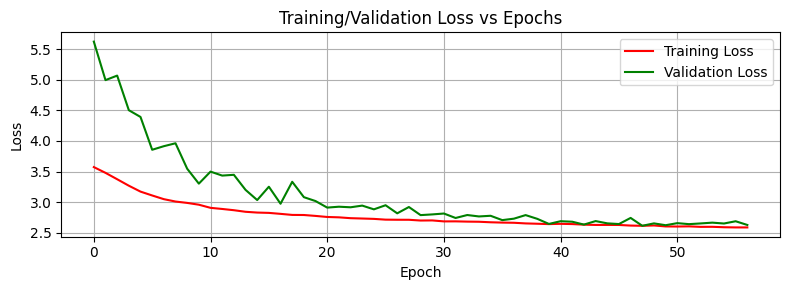


--- Running Final Test Examples ---
Loading best weights from models_pytorch/lipnet_checkpoint.pth for final test...
Best weights loaded successfully.

--- Example Predictions ---
Original:     place green with r seven again
Filtered Idx: [14]
Prediction:   n
--------------------------------------------------
Original:     bin green with u nine again
Filtered Idx: [14]
Prediction:   n
--------------------------------------------------
--- End Examples ---

--- Final Testing Finished ---


In [26]:
# --- Plotting Training/Validation Loss ---
plt.figure(figsize=(8, 3))
# plt.plot(range(1, (EPOCHS - start_epoch) + 1), train_losses, color='red', label="Training Loss")
# plt.plot(range(1, (EPOCHS - start_epoch) + 1), val_losses, color='green', label="Validation Loss")
plt.plot(train_losses, color='red', label="Training Loss")
plt.plot(val_losses, color='green', label="Validation Loss")
plt.title("Training/Validation Loss vs Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve_pytorch.png")
plt.show()

# --- Final Testing Example (similar to TF code) ---
print("\n--- Running Final Test Examples ---")
# Load best weights
if os.path.exists(checkpoint_path):
    print(f"Loading best weights from {checkpoint_path} for final test...")
    try:
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Best weights loaded successfully.")
    except Exception as e:
        print(f"Error loading best weights: {e}")
else:
    print("No checkpoint found for final testing.")

produce_example(model, test_loader, num_to_char_dict) # Show examples with best model
print("--- Final Testing Finished ---")

In [39]:
# import numpy as np
# import glob
# import os

# BASE_PROCESSED_PATH = './processed_mouth_data/'
# FRAME_HEIGHT = 50
# FRAME_WIDTH = 100
# FRAME_CHANNELS = 3
# TARGET_SHAPE_LAST_DIMS = (75, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS)

# print(f"Checking .npy files in {BASE_PROCESSED_PATH}...")
# problem_files = []
# all_files = glob.glob(os.path.join(BASE_PROCESSED_PATH, 's*', '*.npy'))

# if not all_files:
#     print("No .npy files found. Make sure BASE_PROCESSED_PATH is correct.")
# else:
#     print(f"Found {len(all_files)} files. Checking shapes...")
#     for npy_file in all_files:
#         try:
#             data = np.load(npy_file)
#             if data.ndim != 4 or data.shape[:] != TARGET_SHAPE_LAST_DIMS:
#                 print(f"PROBLEM: {npy_file} has shape {data.shape}")
#                 problem_files.append(npy_file)
#         except Exception as e:
#             print(f"ERROR reading {npy_file}: {e}")
#             problem_files.append(npy_file)

#     if not problem_files:
#         print("All checked .npy files seem to have correct H, W, C dimensions.")
#     else:
#         print(f"\nFound {len(problem_files)} files with potential shape issues.")
#         # Optionally, you could delete or reprocess these problem files
#         for f_path in problem_files:
#             os.remove(f_path)
#         print("Problematic files removed. Please re-run preprocessing.")

Checking .npy files in ./processed_mouth_data/...
Found 1000 files. Checking shapes...
PROBLEM: ./processed_mouth_data/s1/lrae3s_mouth.npy has shape (74, 50, 100, 3)
PROBLEM: ./processed_mouth_data/s1/sbbbzp_mouth.npy has shape (74, 50, 100, 3)
PROBLEM: ./processed_mouth_data/s1/srbb4n_mouth.npy has shape (74, 50, 100, 3)
PROBLEM: ./processed_mouth_data/s1/srwi5a_mouth.npy has shape (74, 50, 100, 3)
PROBLEM: ./processed_mouth_data/s1/swao7a_mouth.npy has shape (74, 50, 100, 3)

Found 5 files with potential shape issues.
Problematic files removed. Please re-run preprocessing.
